In [1]:
# ============================================================
# pruning_stage2_sad.py  (Stage-2 for SAD PFML)
# IC²–ASTER FFN neuron pruning (Transformer FFN filter pruning)
# + PFML retraining (same PFML structure as your Stage-1)
#
# - Load data from SAD npz cache
# - Load Stage-1 checkpoints (global/hyper/embed)
# - Print params before/after pruning
# - Prune FFN neurons with IC² (capacity+independence) + ASTER sensitivity
# - Retrain PFML for 50 rounds (configurable)
# ============================================================

import os
import copy
import random
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict, Counter
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SAD cache
SAVE_NPZ_CACHE = True
CACHE_PATH = r"E:\Duc\Safety Driving (2)\Safety Driving\SAD\SAD_cache_paper_hp1.0_lp50.0_fs128_t-3.0_0.0_aug1x1_minAfterAug0.npz"

SAD_C = 33
SAD_T = 385

# PFML / train
BATCH_SIZE = 64
QR_SPLIT_RATE = 0.6


# PFML stage-2 retrain rounds
NUM_ROUNDS_STAGE2 = 100  # <-- bạn muốn 50 rounds ở stage-2
INNER_LR = 1e-3
OUTTER_LR = 1e-3
INNER_STEP = 5
OUTTER_STEP = 1
P_RATE = 0.6


# model
D_MODEL = 64
N_HEAD = 4
N_LAYERS = 5

# hypernet
EMBED_DIM = 16
HIDDEN_DIM = 128
# HYPER_LR = 1e-3
# EMBED_LR = 1e-3
HYPER_LR = 5e-4
EMBED_LR = 5e-4
# hypernet supervision weight (server-side)
LAMBDA_HYPER = 1.0
# ------------------------------------------------------------
# Pruning config
# ------------------------------------------------------------
PRUNE_RATIO = 0.50     # cắt 50% FFN neurons
SIGMA = 0.5            # IC² mixing: capacity vs independence
ALPHA = 1.0            # ASTER sensitivity exponent (>=0)
K_NN = 5               # kNN for independence
N_BINS = 32            # entropy bins


In [3]:

# Optional: use best
# ✅ Stage-1 paper-style checkpoints (best by VAL/QUERY)
CKPT_GLOBAL = "PFML_bestVAL_global.pth"
CKPT_HYPER  = "PFML_bestVAL_hypernet.pth"
CKPT_EMBED  = "PFML_bestVAL_embed.pth"
CKPT_META   = "PFML_bestVAL_meta1.json"   # (optional) chứa best_p_rate


In [4]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def compute_class_weights(subjects_Y):
    from collections import Counter
    import numpy as np

    cnt = Counter()
    for y in subjects_Y:
        cnt.update(y.tolist())

    total = cnt[0] + cnt[1]

    # raw inverse-frequency
    w0 = total / (2.0 * cnt[0])
    w1 = total / (2.0 * cnt[1])

    # 🔥 CORE FIX: temper the weights (sqrt)
    w0 = np.sqrt(w0)
    w1 = np.sqrt(w1)

    print(f"[Class Weight TEMPERED] class0={w0:.3f}, class1={w1:.3f}")

    return torch.tensor([w0, w1], dtype=torch.float32)


In [5]:

# ============================================================
# 1) Support / Query split
# ============================================================
def zscore_per_trial(X: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """
    X: (N, C, T)
    Z-score per trial, per channel (normalize across time axis).
    """
    mu = X.mean(axis=-1, keepdims=True)
    sd = X.std(axis=-1, keepdims=True)
    return (X - mu) / (sd + eps)



In [6]:
# ============================================================
# 1) Train/Test + Support/Query split (paper-grade)
def make_train_support_query_test_sets(subjects_X, subjects_Y,
                                       train_rate=0.7, qr_split_rate=0.6,
                                       do_zscore=True):
    """
    Per subject:
      - split into train/test (70/30)
      - inside train: split into support/query (60/40)
    Returns:
      sup_sets, que_sets, test_sets (TensorDataset lists, aligned per subject)
    """
    sup_sets, que_sets, test_sets = [], [], []

    for X, Y in zip(subjects_X, subjects_Y):
        n = len(X)
        idx = np.arange(n)
        np.random.shuffle(idx)

        n_train = int(n * train_rate)
        tr_idx = idx[:n_train]
        te_idx = idx[n_train:]

        Xtr, Ytr = X[tr_idx], Y[tr_idx]
        Xte, Yte = X[te_idx], Y[te_idx]

        # split train -> support/query
        n_tr = len(Xtr)
        tr2 = np.arange(n_tr)
        np.random.shuffle(tr2)

        n_sup = int(n_tr * qr_split_rate)
        sup_idx = tr2[:n_sup]
        que_idx = tr2[n_sup:]

        Xsup, Ysup = Xtr[sup_idx], Ytr[sup_idx]
        Xque, Yque = Xtr[que_idx], Ytr[que_idx]

        # ✅ normalize (per trial, per channel)
        if do_zscore:
            Xsup = zscore_per_trial(Xsup).astype(np.float32)
            Xque = zscore_per_trial(Xque).astype(np.float32)
            Xte  = zscore_per_trial(Xte ).astype(np.float32)
        else:
            Xsup = Xsup.astype(np.float32)
            Xque = Xque.astype(np.float32)
            Xte  = Xte.astype(np.float32)

        sup_sets.append(TensorDataset(torch.from_numpy(Xsup), torch.from_numpy(Ysup).long()))
        que_sets.append(TensorDataset(torch.from_numpy(Xque), torch.from_numpy(Yque).long()))
        test_sets.append(TensorDataset(torch.from_numpy(Xte ), torch.from_numpy(Yte ).long()))
    
    
    return sup_sets, que_sets, test_sets


In [7]:
# ============================================================
# 2) Model (same as your Stage-1) + prunable FFN dim
# ============================================================
class TemporalAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.Tanh(),
            nn.Linear(d_model // 2, 1),
        )
    def forward(self, x):
        w = self.attn(x)                # (B,T,1)
        alpha = torch.softmax(w, dim=1) # (B,T,1)
        return (x * alpha).sum(dim=1)   # (B,D)

class EEGTransformerPrunable(nn.Module):
    """
    Exactly your EEGTransformer, but allow ff_dim to change.
    """
    def __init__(self, C=33, T=250, d_model=64, nhead=4, num_layers=6, ff_dim=128, num_classes=2):
        super().__init__()
        self.C = C
        self.T = T
        self.d_model = d_model
        self.ff_dim = ff_dim

        self.spatial_conv = nn.Conv1d(C, C, kernel_size=1, groups=1, bias=False)
        self.temporal_conv = nn.Conv1d(C, C, kernel_size=7, padding=3, groups=C, bias=False)

        self.proj = nn.Linear(C, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=ff_dim,
            dropout=0.1,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers)

        self.temp_attn = TemporalAttention(d_model)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        if x.size(1) != self.C:
            raise RuntimeError(f"[EEGTransformer] Channel mismatch: got {x.size(1)}, expected {self.C}")

        x = self.spatial_conv(x)
        x = self.temporal_conv(x)

        x = x.permute(0, 2, 1)   # (B,T,C)
        h = self.proj(x)         # (B,T,D)
        h = self.encoder(h)      # (B,T,D)
        h = self.temp_attn(h)    # (B,D)
        return self.classifier(h)

In [8]:
# ============================================================
# 3) IC²–ASTER score for FFN neurons
#    v_j = [W1[j,:], W2[:,j]^T] ∈ R^{2d}
#    IMcap: 1 - entropy(|v|)
#    IMind: kNN distance
#    ASTER gate: g_j = ||v||^2, score = (σ cap + (1-σ) ind) * (g_j)^(α)
# ============================================================
def entropy_capacity(v: torch.Tensor, n_bins=32):
    v = v.abs()
    mn, mx = v.min().item(), v.max().item()
    if mx - mn < 1e-12:
        return 0.0
    hist = torch.histc(v, bins=n_bins, min=mn, max=mx)
    p = hist / (hist.sum() + 1e-12)
    H = -(p * (p + 1e-12).log2()).sum().item()
    H_norm = H / (np.log2(n_bins) + 1e-12)
    return 1.0 - H_norm

@torch.no_grad()
def ic2_aster_scores(linear1: nn.Linear, linear2: nn.Linear,
                     sigma=0.5, alpha=1.0, k_nn=5, n_bins=32):
    W1 = linear1.weight.detach().float()      # (ff, d)
    W2 = linear2.weight.detach().float()      # (d, ff)
    ff = W1.shape[0]
    d  = W1.shape[1]

    V = torch.cat([W1, W2.t()], dim=1)        # (ff, 2d)

    # IMcap
    cap = torch.zeros(ff, device=V.device)
    for j in range(ff):
        cap[j] = entropy_capacity(V[j], n_bins=n_bins)

    # IMind (kNN distance in weight space)
    dist = torch.cdist(V, V, p=2)
    dist.fill_diagonal_(float("inf"))
    k = min(k_nn, max(1, ff - 1))
    nn_d = torch.topk(dist, k=k, largest=False).values
    ind = nn_d.mean(dim=1)

    # normalize to [0,1]
    cap_n = (cap - cap.min()) / (cap.max() - cap.min() + 1e-12)
    ind_n = (ind - ind.min()) / (ind.max() - ind.min() + 1e-12)

    O = sigma * cap_n + (1 - sigma) * ind_n

    # ASTER sensitivity gate
    g = (V.norm(p=2, dim=1) ** 2)  # ||v||_2^2
    score = O * (g ** alpha)
    return score  # (ff,)

In [9]:

# ============================================================
# 4) Prune Transformer FFN neurons and rebuild smaller model
# ============================================================
@torch.no_grad()
def prune_ffn_neurons(model_full: EEGTransformerPrunable, prune_ratio=0.5,
                      sigma=0.5, alpha=1.0, k_nn=5, n_bins=32):
    device = next(model_full.parameters()).device
    C = model_full.C
    T = model_full.T
    d_model = model_full.d_model
    nhead = model_full.encoder.layers[0].self_attn.num_heads
    num_layers = len(model_full.encoder.layers)

    ff_full = model_full.encoder.layers[0].linear1.out_features
    ff_keep = max(1, int(np.floor((1 - prune_ratio) * ff_full)))

    model_small = EEGTransformerPrunable(
        C=C, T=T, d_model=d_model, nhead=nhead,
        num_layers=num_layers, ff_dim=ff_keep, num_classes=2
    ).to(device)

    # copy conv/proj/temp_attn/classifier
    model_small.spatial_conv.load_state_dict(model_full.spatial_conv.state_dict(), strict=True)
    model_small.temporal_conv.load_state_dict(model_full.temporal_conv.state_dict(), strict=True)
    model_small.proj.load_state_dict(model_full.proj.state_dict(), strict=True)
    model_small.temp_attn.load_state_dict(model_full.temp_attn.state_dict(), strict=True)
    model_small.classifier.load_state_dict(model_full.classifier.state_dict(), strict=True)

    # copy each encoder layer (attention+norm keep, FFN prune)
    for li in range(num_layers):
        Lf = model_full.encoder.layers[li]
        Ls = model_small.encoder.layers[li]

        # attention & norms
        Ls.self_attn.load_state_dict(Lf.self_attn.state_dict(), strict=True)
        Ls.norm1.load_state_dict(Lf.norm1.state_dict(), strict=True)
        Ls.norm2.load_state_dict(Lf.norm2.state_dict(), strict=True)

        # FFN prune
        scores = ic2_aster_scores(Lf.linear1, Lf.linear2,
                                  sigma=sigma, alpha=alpha, k_nn=k_nn, n_bins=n_bins)
        keep_idx = torch.topk(scores, k=ff_keep, largest=True).indices.sort()[0]

        # linear1: (ff_keep, d_model)
        Ls.linear1.weight.copy_(Lf.linear1.weight[keep_idx])
        Ls.linear1.bias.copy_(Lf.linear1.bias[keep_idx])

        # linear2: (d_model, ff_keep)
        Ls.linear2.weight.copy_(Lf.linear2.weight[:, keep_idx])
        Ls.linear2.bias.copy_(Lf.linear2.bias)

    return model_small


In [10]:

# ============================================================
# 5) Hypernet parts (same logic as your Stage-1)
# ============================================================
class Embed(nn.Module):
    def __init__(self, client_num, emb_dim):
        super().__init__()
        self.embed = nn.Embedding(client_num, emb_dim)
    def forward(self, client_id):
        if not torch.is_tensor(client_id):
            client_id = torch.tensor([client_id], dtype=torch.long, device=self.embed.weight.device)
        return self.embed(client_id)

class HeadHyperNet(nn.Module):
    def __init__(self, embed: Embed, emb_dim=16, hidden_dim=128, d_model=64, num_classes=2):
        super().__init__()
        self.embed = embed
        self.num_classes = num_classes
        self.d_model = d_model

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.w_gen = nn.Linear(hidden_dim, num_classes * d_model)
        self.b_gen = nn.Linear(hidden_dim, num_classes)

    def forward(self, client_id):
        e = self.embed(client_id)
        h = self.mlp(e)
        w = self.w_gen(h).view(self.num_classes, self.d_model)
        # constrained (same as your fix)
        w = w / (w.norm(p=2, dim=1, keepdim=True) + 1e-6)
        b = self.b_gen(h).view(self.num_classes)
        b = torch.clamp(b, -1.0, 1.0)
        return OrderedDict({"classifier.weight": w, "classifier.bias": b})

In [11]:

# ============================================================
# 6) PFML correct evaluation
# ============================================================
@torch.no_grad()
def eval_intra_full_metrics_pfml(trainer, p_rate=None, save_txt=False, out_path="PFML_stage2_intra_results.txt"):
    if p_rate is None:
        p_rate = trainer.p_rate

    global_state = copy.deepcopy(trainer.global_model.state_dict())
    y_true_all, y_pred_all = [], []

    for c in trainer.clients:
        cid = c.cid
        zeta = trainer.hypernet(torch.tensor([cid], dtype=torch.long, device=DEVICE))

        theta = copy.deepcopy(global_state)
        theta["classifier.weight"] = (1.0 - p_rate) * theta["classifier.weight"] + p_rate * zeta["classifier.weight"]
        theta["classifier.bias"]   = (1.0 - p_rate) * theta["classifier.bias"]   + p_rate * zeta["classifier.bias"]

        model = trainer.model_ctor().to(DEVICE)
        model.load_state_dict(theta, strict=True)
        model.eval()

        for xb, yb in c.que_loader:
            xb = xb.to(DEVICE)
            logits = model(xb)
            pred = logits.argmax(1).cpu().numpy()
            y_true_all.append(yb.numpy())
            y_pred_all.append(pred)

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    acc = accuracy_score(y_true_all, y_pred_all)
    macro_f1 = f1_score(y_true_all, y_pred_all, average="macro")
    cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1])

    print("\n================ PFML-CORRECT INTRA EVAL (Stage-2) ================")
    print(f"Accuracy  : {acc*100:.2f}%")
    print(f"Macro-F1  : {macro_f1*100:.2f}%")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_true_all, y_pred_all, digits=4, zero_division=0))
    print("===================================================================\n")

    if save_txt:
        with open(out_path, "w") as f:
            f.write(f"Accuracy  : {acc*100:.2f}%\n")
            f.write(f"Macro-F1  : {macro_f1*100:.2f}%\n")
            f.write("Confusion Matrix:\n")
            f.write(str(cm) + "\n\n")
            f.write(classification_report(y_true_all, y_pred_all, digits=4, zero_division=0))

    return acc, macro_f1, cm

In [12]:

import re

def _safe_name(s: str) -> str:
    return re.sub(r"[^a-zA-Z0-9._-]+", "_", str(s))

@torch.no_grad()
def eval_intra_per_subject_pfml(
    trainer,
    p_rate=None,
    save_txt=False,
    print_per_subject=True,
    tag="VAL",
    use_eval_loader=True,
    out_path=None
):
    """
    PFML intra eval (QUERY):
    - personalized model per client (subject)
    - metrics per subject
    - report Mean±Std over subjects + micro reference
    - if use_eval_loader=True: dùng que_eval_loader (shuffle=False, drop_last=False)
    """
    if p_rate is None:
        p_rate = trainer.p_rate

    global_state = copy.deepcopy(trainer.global_model.state_dict())

    per_sub = []
    y_true_micro, y_pred_micro = [], []

    for c in trainer.clients:
        cid = c.cid

        # hyper head
        zeta = trainer.hypernet(torch.tensor([cid], dtype=torch.long, device=DEVICE))

        # personalized theta
        theta = copy.deepcopy(global_state)
        theta["classifier.weight"] = (1.0 - p_rate) * theta["classifier.weight"] + p_rate * zeta["classifier.weight"]
        theta["classifier.bias"]   = (1.0 - p_rate) * theta["classifier.bias"]   + p_rate * zeta["classifier.bias"]

        model = trainer.model_ctor().to(DEVICE)
        model.load_state_dict(theta, strict=True)
        model.eval()

        loader = c.que_eval_loader if use_eval_loader else c.que_loader

        ys, ps = [], []
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            logits = model(xb)
            pred = logits.argmax(1).cpu().numpy()
            ys.append(yb.numpy())
            ps.append(pred)

        ys = np.concatenate(ys) if len(ys) else np.array([], dtype=np.int64)
        ps = np.concatenate(ps) if len(ps) else np.array([], dtype=np.int64)
        if len(ys) == 0:
            continue

        acc_i = accuracy_score(ys, ps)
        f1_i  = f1_score(ys, ps, average="macro")
        cm_i  = confusion_matrix(ys, ps, labels=[0, 1])

        per_sub.append({"cid": cid, "n": len(ys), "acc": acc_i, "macro_f1": f1_i, "cm": cm_i})

        y_true_micro.append(ys)
        y_pred_micro.append(ps)

    # macro over subjects
    acc_list = np.array([d["acc"] for d in per_sub], dtype=np.float32)
    f1_list  = np.array([d["macro_f1"] for d in per_sub], dtype=np.float32)

    if len(acc_list) > 1:
        acc_mean, acc_std = acc_list.mean(), acc_list.std(ddof=1)
    else:
        acc_mean, acc_std = (acc_list.mean() if len(acc_list) else 0.0), 0.0

    if len(f1_list) > 1:
        f1_mean, f1_std = f1_list.mean(), f1_list.std(ddof=1)
    else:
        f1_mean, f1_std = (f1_list.mean() if len(f1_list) else 0.0), 0.0

    # micro overall (reference)
    y_true_micro = np.concatenate(y_true_micro) if len(y_true_micro) else np.array([], dtype=np.int64)
    y_pred_micro = np.concatenate(y_pred_micro) if len(y_pred_micro) else np.array([], dtype=np.int64)

    micro_acc = accuracy_score(y_true_micro, y_pred_micro) if len(y_true_micro) else 0.0
    micro_f1  = f1_score(y_true_micro, y_pred_micro, average="macro") if len(y_true_micro) else 0.0

    print(f"\n================ PFML INTRA ({tag}) ================")
    print(f"Subjects used : {len(per_sub)}")
    print(f"Mean ACC      : {acc_mean*100:.2f}%  (Std {acc_std*100:.2f}%)")
    print(f"Mean Macro-F1 : {f1_mean*100:.2f}%  (Std {f1_std*100:.2f}%)")
   
    print("====================================================\n")

    if print_per_subject:
        print("Per-subject results:")
        for d in per_sub:
            print(f"  cid={d['cid']:>2} | N={d['n']:>5} | ACC={d['acc']*100:>6.2f}% | Macro-F1={d['macro_f1']*100:>6.2f}%")

    if save_txt:
        if out_path is None:
            out_path = f"PFML_intra_{_safe_name(tag)}.txt"
        with open(out_path, "w") as f:
            f.write(f"Subjects used : {len(per_sub)}\n")
            f.write(f"Mean ACC      : {acc_mean*100:.2f}% (Std {acc_std*100:.2f}%)\n")
            f.write(f"Mean Macro-F1 : {f1_mean*100:.2f}% (Std {f1_std*100:.2f}%)\n")
            f.write(f"Micro ACC     : {micro_acc*100:.2f}%\n")
            f.write(f"Micro Macro-F1: {micro_f1*100:.2f}%\n\n")
            for d in per_sub:
                f.write(f"cid={d['cid']} N={d['n']} ACC={d['acc']*100:.2f} Macro-F1={d['macro_f1']*100:.2f}\n")

    return per_sub, (acc_mean, acc_std), (f1_mean, f1_std)

In [13]:
# ============================================================
# 6) Client: meta-train with support/query (inner/outer)
# ============================================================
class MetaClient:
    def __init__(self, cid, innerlr, outterlr,
                 inner_step, outter_step,
                 batch_size, class_weights):
        self.cid = cid
        self.innerlr = innerlr
        self.outterlr = outterlr
        self.inner_step = inner_step
        self.outter_step = outter_step
        self.batch_size = batch_size

        self.criterion = nn.CrossEntropyLoss(weight=class_weights)

        self.sup_loader = None
        self.que_loader = None
        self.test_loader = None

        # eval loaders (no shuffle / no drop_last)
        self.que_eval_loader = None
        self.test_eval_loader = None

    def init_dataset(self, sup_set, que_set, test_set):
        # train-time loaders
        self.sup_loader = DataLoader(sup_set, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.que_loader = DataLoader(que_set, batch_size=self.batch_size, shuffle=True, drop_last=False)
        self.test_loader = DataLoader(test_set, batch_size=self.batch_size, shuffle=False, drop_last=False)

        # eval loaders (full)
        self.que_eval_loader = DataLoader(que_set, batch_size=self.batch_size, shuffle=False, drop_last=False)
        self.test_eval_loader = self.test_loader

    @staticmethod
    def _next_batch(loader, it_state):
        try:
            batch = next(it_state["it"])
        except StopIteration:
            it_state["it"] = iter(loader)
            batch = next(it_state["it"])
        return batch

    def train(self, hyper_head, global_state, p_rate, model_ctor):
        """
        Returns:
          outer_state (for FedAvg global update),
          ft_head_target (for hypernet supervision),
          inner_acc/loss, outer_acc/loss
        """

        # (1) mix global head with hyper head
        theta = copy.deepcopy(global_state)
        gw = theta["classifier.weight"]
        gb = theta["classifier.bias"]
        theta["classifier.weight"] = (1 - p_rate) * gw + p_rate * hyper_head["classifier.weight"]
        theta["classifier.bias"]   = (1 - p_rate) * gb + p_rate * hyper_head["classifier.bias"]

        # ---------------- INNER: support fine-tune ----------------
        fast_model = model_ctor().to(DEVICE)
        fast_model.load_state_dict(theta, strict=True)
        inner_opt = torch.optim.Adam(fast_model.parameters(), lr=self.innerlr)

        sup_it = {"it": iter(self.sup_loader)}
        total_loss, total_correct, total_sample = 0, 0, 0

        for _ in range(self.inner_step):
            xb, yb = self._next_batch(self.sup_loader, sup_it)
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            inner_opt.zero_grad()
            logits = fast_model(xb)
            loss = self.criterion(logits, yb)
            loss.backward()
            inner_opt.step()

            total_loss += loss.item() * xb.size(0)
            total_correct += (logits.argmax(1) == yb).sum().item()
            total_sample += xb.size(0)

        inner_acc  = total_correct / max(1, total_sample)
        inner_loss = total_loss / max(1, total_sample)

        fast_state = copy.deepcopy(fast_model.state_dict())

        # target head for hypernet supervision (detach)
        ft_head_target = {
            "classifier.weight": fast_state["classifier.weight"].detach().clone(),
            "classifier.bias":   fast_state["classifier.bias"].detach().clone()
        }

        # ---------------- OUTER: query step from fast weights ----------------
        # IMPORTANT: start from fast_model (after inner), not from theta
        outer_model = model_ctor().to(DEVICE)
        outer_model.load_state_dict(fast_state, strict=True)
        out_opt = torch.optim.Adam(outer_model.parameters(), lr=self.outterlr)

        que_it = {"it": iter(self.que_loader)}
        total_loss, total_correct, total_sample = 0, 0, 0

        for _ in range(self.outter_step):
            xb, yb = self._next_batch(self.que_loader, que_it)
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            out_opt.zero_grad()
            logits = outer_model(xb)
            loss = self.criterion(logits, yb)
            loss.backward()
            out_opt.step()

            total_loss += loss.item() * xb.size(0)
            total_correct += (logits.argmax(1) == yb).sum().item()
            total_sample += xb.size(0)

        out_acc  = total_correct / max(1, total_sample)
        out_loss = total_loss / max(1, total_sample)

        outer_state = copy.deepcopy(outer_model.state_dict())
        return outer_state, ft_head_target, inner_acc, inner_loss, out_acc, out_loss

In [14]:
@torch.no_grad()
def eval_test_per_subject_pfml(
    trainer,
    p_rate=None,
    save_txt=False,
    tag="TEST",
    print_per_subject=True,
    print_cm_per_subject=False,
    out_path="PFML_test_detail.txt"
):
    """
    Evaluate on held-out TEST split (per subject), using personalized head mixing.
    Reports mean±std over subjects + overall confusion matrix.
    """
    if p_rate is None:
        p_rate = trainer.p_rate

    global_state = copy.deepcopy(trainer.global_model.state_dict())

    per_sub = []
    y_true_all, y_pred_all = [], []

    for c in trainer.clients:
        cid = c.cid
        zeta = trainer.hypernet(torch.tensor([cid], dtype=torch.long, device=DEVICE))

        theta = copy.deepcopy(global_state)
        theta["classifier.weight"] = (1.0 - p_rate) * theta["classifier.weight"] + p_rate * zeta["classifier.weight"]
        theta["classifier.bias"]   = (1.0 - p_rate) * theta["classifier.bias"]   + p_rate * zeta["classifier.bias"]

        model = trainer.model_ctor().to(DEVICE)
        model.load_state_dict(theta, strict=True)
        model.eval()

        ys, ps = [], []
        for xb, yb in c.test_eval_loader:  # shuffle=False, drop_last=False
            xb = xb.to(DEVICE)
            logits = model(xb)
            pred = logits.argmax(1).cpu().numpy()
            ys.append(yb.numpy())
            ps.append(pred)

        ys = np.concatenate(ys) if len(ys) else np.array([], dtype=np.int64)
        ps = np.concatenate(ps) if len(ps) else np.array([], dtype=np.int64)
        if len(ys) == 0:
            continue

        acc_i = accuracy_score(ys, ps)
        f1_i  = f1_score(ys, ps, average="macro")
        cm_i  = confusion_matrix(ys, ps, labels=[0, 1])

        per_sub.append({"cid": cid, "n": len(ys), "acc": acc_i, "macro_f1": f1_i, "cm": cm_i})

        y_true_all.append(ys)
        y_pred_all.append(ps)

    # macro over subjects
    acc_list = np.array([d["acc"] for d in per_sub], dtype=np.float32)
    f1_list  = np.array([d["macro_f1"] for d in per_sub], dtype=np.float32)

    acc_mean = acc_list.mean() if len(acc_list) else 0.0
    acc_std  = acc_list.std(ddof=1) if len(acc_list) > 1 else 0.0
    f1_mean  = f1_list.mean() if len(f1_list) else 0.0
    f1_std   = f1_list.std(ddof=1) if len(f1_list) > 1 else 0.0

    y_true_all = np.concatenate(y_true_all) if len(y_true_all) else np.array([], dtype=np.int64)
    y_pred_all = np.concatenate(y_pred_all) if len(y_pred_all) else np.array([], dtype=np.int64)
    cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1]) if len(y_true_all) else np.zeros((2, 2), dtype=int)

    print(f"\n================ PFML {tag} (TEST) ================")
    print(f"Subjects used : {len(per_sub)}")
    print(f"Mean ACC      : {acc_mean*100:.2f}%  (Std {acc_std*100:.2f}%)")
    print(f"Mean Macro-F1 : {f1_mean*100:.2f}%  (Std {f1_std*100:.2f}%)")
    print("Overall Confusion Matrix (all test samples):")
    print(cm)

    if print_per_subject:
        print("\nPer-subject results:")
        print("  cid |     N |   ACC   | Macro-F1")
        print("------|-------|---------|---------")
        for d in per_sub:
            print(f"  {d['cid']:>3} | {d['n']:>5} | {d['acc']*100:>6.2f}% | {d['macro_f1']*100:>7.2f}%")

        if print_cm_per_subject:
            print("\nPer-subject Confusion Matrices:")
            for d in per_sub:
                print(f"[cid={d['cid']}] cm=\n{d['cm']}\n")

    print("====================================================\n")

    if save_txt:
        with open(out_path, "w") as f:
            f.write(f"Subjects used : {len(per_sub)}\n")
            f.write(f"Mean ACC      : {acc_mean*100:.2f}% (Std {acc_std*100:.2f}%)\n")
            f.write(f"Mean Macro-F1 : {f1_mean*100:.2f}% (Std {f1_std*100:.2f}%)\n")
            f.write("Overall Confusion Matrix:\n")
            f.write(str(cm) + "\n\n")
            f.write("Per-subject:\n")
            for d in per_sub:
                f.write(f"cid={d['cid']} N={d['n']} ACC={d['acc']*100:.2f} Macro-F1={d['macro_f1']*100:.2f}\n")
                if print_cm_per_subject:
                    f.write(f"cm=\n{d['cm']}\n\n")

    return per_sub, (acc_mean, acc_std), (f1_mean, f1_std), cm

In [15]:
# ============================================================
# PFML Trainer (Stage-2) - paper style like Stage-1
#   - Select best by VAL(QUERY)
#   - TEST only once at the end (outside trainer)
#   - Hypernet supervision via MSE on classifier head
# ============================================================
class PFMLTrainer:
    def __init__(self, num_client, batch_size, qr_split_rate,
                 innerlr, outterlr, innerstep, outterstep, p_rate,
                 ff_dim, class_weights,
                 init_global_state=None,
                 init_hyper_state=None,
                 init_embed_state=None):

        self.num_client = num_client
        self.batch_size = batch_size
        self.qr_split_rate = qr_split_rate

        self.innerlr = innerlr
        self.outterlr = outterlr
        self.innerstep = innerstep
        self.outterstep = outterstep
        self.p_rate = p_rate

        self.class_weights = class_weights
        self.ff_dim = ff_dim

        # pruned backbone ctor
        self.model_ctor = lambda: EEGTransformerPrunable(
            C=SAD_C, T=SAD_T, d_model=D_MODEL, nhead=N_HEAD, num_layers=N_LAYERS,
            ff_dim=self.ff_dim, num_classes=2
        )

        # global model
        self.global_model = self.model_ctor().to(DEVICE)
        if init_global_state is not None:
            self.global_model.load_state_dict(init_global_state, strict=True)

        # hypernet + embed
        self.embed = Embed(self.num_client, EMBED_DIM).to(DEVICE)
        self.hypernet = HeadHyperNet(self.embed, EMBED_DIM, HIDDEN_DIM, D_MODEL, 2).to(DEVICE)

        if init_embed_state is not None:
            self.embed.load_state_dict(init_embed_state, strict=True)
        if init_hyper_state is not None:
            self.hypernet.load_state_dict(init_hyper_state, strict=True)

        # optimizers (same as stage-1)
        self.hyper_opt = torch.optim.Adam(
            [p for n, p in self.hypernet.named_parameters() if "embed" not in n],
            lr=HYPER_LR
        )
        self.embed_opt = torch.optim.Adam(self.embed.parameters(), lr=EMBED_LR)

        self.clients = []

        # ============================================================
        # [ADD] history for plotting (round-wise)
        # ============================================================
        self.history = {
            "round": [],
            "p_rate": [],
            "val_acc_mean": [],
            "val_acc_std": [],
            "val_f1_mean": [],
            "val_f1_std": [],
            "hyper_loss": [],        # mean hyper loss per round
            "inner_loss_mean": [],   # mean over clients per round
            "outer_loss_mean": [],   # mean over clients per round
            "inner_acc_mean": [],    # optional
            "outer_acc_mean": [],    # optional
        }

    def init_clients(self, sup_sets, que_sets, test_sets):
        self.clients = []
        for cid in range(self.num_client):
            c = MetaClient(
                cid,
                self.innerlr,
                self.outterlr,
                self.innerstep,
                self.outterstep,
                self.batch_size,
                self.class_weights
            )
            c.init_dataset(sup_sets[cid], que_sets[cid], test_sets[cid])
            self.clients.append(c)
        print(f"[PFML] Created {len(self.clients)} clients.")

    def fedavg(self, model_states):
        avg = OrderedDict()
        for k in model_states[0].keys():
            avg[k] = sum(ms[k] for ms in model_states) / len(model_states)
        return avg

    def run(self, num_rounds, save_prefix="PFML_stage2"):
        print(f"[PFML Stage-2] Start training on {DEVICE}, rounds={num_rounds}, ff_dim={self.ff_dim}")

        best_val_acc = 0.0
        best_round = 0
        best_p_rate = None

        mse = nn.MSELoss()

        for rnd in range(1, num_rounds + 1):
            # schedule p_rate (same as stage-1)
            p_rate_rnd = self.p_rate  # fixed


            outer_states = []
            global_state = copy.deepcopy(self.global_model.state_dict())

            # -------- server-side hypernet supervised loss --------
            hyper_loss_total = 0.0

            # ============================================================
            # [ADD] round-wise accumulators for inner/outer stats
            # ============================================================
            inner_loss_sum = 0.0
            outer_loss_sum = 0.0
            inner_acc_sum  = 0.0
            outer_acc_sum  = 0.0
            n_clients_used = 0

            for c in self.clients:
                cid_t = torch.tensor([c.cid], dtype=torch.long, device=DEVICE)

                # zeta_i from hypernet (keep graph)
                zeta = self.hypernet(cid_t)

                # client local meta-learning
                outer_state, ft_head_target, inner_acc, inner_loss, out_acc, out_loss = c.train(
                    zeta, global_state, p_rate_rnd, self.model_ctor
                )
                outer_states.append(outer_state)

                # ============================================================
                # [ADD] accumulate inner/outer stats
                # ============================================================
                inner_loss_sum += float(inner_loss)
                outer_loss_sum += float(out_loss)
                inner_acc_sum  += float(inner_acc)
                outer_acc_sum  += float(out_acc)
                n_clients_used += 1

                # hypernet supervision
                hyper_loss = mse(zeta["classifier.weight"], ft_head_target["classifier.weight"]) + \
                             mse(zeta["classifier.bias"],   ft_head_target["classifier.bias"])
                hyper_loss_total = hyper_loss_total + hyper_loss

            # (1) update global by FedAvg
            self.global_model.load_state_dict(self.fedavg(outer_states), strict=True)

            # (2) update hypernet + embed
            self.hyper_opt.zero_grad()
            self.embed_opt.zero_grad()
            (LAMBDA_HYPER * hyper_loss_total / max(1, len(self.clients))).backward()
            self.hyper_opt.step()
            self.embed_opt.step()

            # ============================================================
            # [ADD] round-wise means for inner/outer
            # ============================================================
            inner_loss_mean = inner_loss_sum / max(1, n_clients_used)
            outer_loss_mean = outer_loss_sum / max(1, n_clients_used)
            inner_acc_mean  = inner_acc_sum  / max(1, n_clients_used)
            outer_acc_mean  = outer_acc_sum  / max(1, n_clients_used)

            # (3) VAL = QUERY (paper-grade model selection)
            # ✅ per-subject giống stage-1 -> dùng que_eval_loader (shuffle=False)
            per_sub, acc_stat, f1_stat = eval_intra_per_subject_pfml(
                self,
                p_rate=p_rate_rnd,
                save_txt=False,
                print_per_subject=True,   # <-- đổi False nếu muốn gọn log
                tag=f"VAL@Round{rnd:03d}",
                use_eval_loader=True
            )
            val_acc_mean, val_acc_std = acc_stat
            val_f1_mean,  val_f1_std  = f1_stat

            # ============================================================
            # [ADD] push to history for plotting
            # ============================================================
            self.history["round"].append(int(rnd))
            self.history["p_rate"].append(float(p_rate_rnd))
            self.history["val_acc_mean"].append(float(val_acc_mean))
            self.history["val_acc_std"].append(float(val_acc_std))
            self.history["val_f1_mean"].append(float(val_f1_mean))
            self.history["val_f1_std"].append(float(val_f1_std))
            self.history["hyper_loss"].append(float(hyper_loss_total.item() / max(1, len(self.clients))))
            self.history["inner_loss_mean"].append(float(inner_loss_mean))
            self.history["outer_loss_mean"].append(float(outer_loss_mean))
            self.history["inner_acc_mean"].append(float(inner_acc_mean))
            self.history["outer_acc_mean"].append(float(outer_acc_mean))

            # ============================================================
            # [ADD] print p_rate on the same line
            # ============================================================
            print(
                f"[ROUND {rnd:03d}] "
                f"VAL(QUERY) Per-Subject ACC = {val_acc_mean*100:.2f}% ± {val_acc_std*100:.2f}% | "
                f"Macro-F1 = {val_f1_mean*100:.2f}% ± {val_f1_std*100:.2f}% | "
                f"HyperLoss={(hyper_loss_total.item()/max(1,len(self.clients))):.6f} | "
                f"p_rate={p_rate_rnd:.3f}"
            )

            # ✅ select best by VAL/QUERY
            if val_acc_mean > best_val_acc:
                best_val_acc = val_acc_mean
                best_round = rnd
                best_p_rate = p_rate_rnd

                torch.save(self.global_model.state_dict(), f"{save_prefix}_bestVAL_global.pth")
                torch.save(self.hypernet.state_dict(), f"{save_prefix}_bestVAL_hypernet.pth")
                torch.save(self.embed.state_dict(), f"{save_prefix}_bestVAL_embed.pth")

                meta = {
                    "best_round": int(best_round),
                    "best_val_acc": float(best_val_acc),
                    "best_p_rate": float(best_p_rate),
                    "ff_dim": int(self.ff_dim),
                    "prune_ratio": float(PRUNE_RATIO) if "PRUNE_RATIO" in globals() else None
                }
                import json
                with open(f"{save_prefix}_bestVAL_meta.json", "w") as f:
                    json.dump(meta, f, indent=2)

                print(f"🔥 NEW BEST (by VAL/QUERY) @ Round {rnd} | Acc={best_val_acc*100:.2f}% | p_rate={best_p_rate:.3f}")

        print("\n================ STAGE-2 BEST SUMMARY ================")
        print(f"Best VAL(QUERY) Accuracy : {best_val_acc*100:.2f}%")
        print(f"Best Round               : {best_round}")
        print(f"Best p_rate              : {best_p_rate}")
        print("Saved checkpoints:")
        print(f" - {save_prefix}_bestVAL_global.pth")
        print(f" - {save_prefix}_bestVAL_hypernet.pth")
        print(f" - {save_prefix}_bestVAL_embed.pth")
        print(f" - {save_prefix}_bestVAL_meta.json")
        print("======================================================")

        # optional: save final
        torch.save(self.global_model.state_dict(), f"{save_prefix}_final_global.pth")
        torch.save(self.hypernet.state_dict(), f"{save_prefix}_final_hypernet.pth")
        torch.save(self.embed.state_dict(), f"{save_prefix}_final_embed.pth")
        print("\nSaved final:")
        print(f" - {save_prefix}_final_global.pth")
        print(f" - {save_prefix}_final_hypernet.pth")
        print(f" - {save_prefix}_final_embed.pth")


In [16]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def load_pfml_npz_grouped(npz_path):
    """
    Load SAD cache (grouped by subject) for PFML.
    Expected keys:
      - subjects_X: list of (Ni, C, T)
      - subjects_Y: list of (Ni,)
      - subjects   : list of subject IDs (optional)
    """
    data = np.load(npz_path, allow_pickle=True)

    subjects_X = list(data["subjects_X"])
    subjects_Y = list(data["subjects_Y"])

    if "subjects" in data.files:
        subject_ids = list(data["subjects"])
    else:
        subject_ids = list(range(len(subjects_X)))

    # sanity
    assert len(subjects_X) == len(subjects_Y), "X/Y subject count mismatch"

    total_samples = sum(len(x) for x in subjects_X)
    print(f"[LOADER] Subjects={len(subjects_X)} | Total samples={total_samples}")

    return subjects_X, subjects_Y, subject_ids


In [17]:
# ============================================================
# 8) MAIN (script-style, no def main)
# ============================================================

set_seed(SEED)

# ============================================================
# 1) Load cache
# ============================================================
if SAVE_NPZ_CACHE and os.path.exists(CACHE_PATH):
    print(f"[CACHE] Loading {CACHE_PATH}")
    subjects_X, subjects_Y, subject_ids = load_pfml_npz_grouped(CACHE_PATH)
else:
    raise FileNotFoundError(f"Missing cache: {CACHE_PATH}")

print("[SANITY] subjects:", len(subjects_X))
print("[SANITY] X0 shape:", subjects_X[0].shape, "Y0 shape:", subjects_Y[0].shape)

num_client = len(subjects_X)
print(f"\nTotal clients(subjects): {num_client}")
if num_client < 2:
    raise RuntimeError("Need at least 2 subjects/clients.")

# ============================================================
# 2) Class weights
# ============================================================
class_weights = compute_class_weights(subjects_Y).to(DEVICE)

# ============================================================
# 3) Paper-style split: Train/Test → Support/Query
# ============================================================
TRAIN_RATE = 0.7
sup_sets, que_sets, test_sets = make_train_support_query_test_sets(
    subjects_X, subjects_Y,
    train_rate=TRAIN_RATE,
    qr_split_rate=QR_SPLIT_RATE
)

# ============================================================
# 4) Build full model + load Stage-1 checkpoints
# ============================================================
ff_full = 2 * D_MODEL
model_full = EEGTransformerPrunable(
    C=SAD_C, T=SAD_T,
    d_model=D_MODEL, nhead=N_HEAD,
    num_layers=N_LAYERS,
    ff_dim=ff_full,
    num_classes=2
).to(DEVICE)

if os.path.exists(CKPT_GLOBAL):
    model_full.load_state_dict(torch.load(CKPT_GLOBAL, map_location=DEVICE), strict=True)
    print(f"[Load] Global backbone: {CKPT_GLOBAL}")
else:
    raise FileNotFoundError(f"Missing {CKPT_GLOBAL} in current folder.")

hyper_state = torch.load(CKPT_HYPER, map_location=DEVICE) if os.path.exists(CKPT_HYPER) else None
embed_state = torch.load(CKPT_EMBED, map_location=DEVICE) if os.path.exists(CKPT_EMBED) else None
if hyper_state is not None:
    print(f"[Load] Hypernet: {CKPT_HYPER}")
if embed_state is not None:
    print(f"[Load] Embed: {CKPT_EMBED}")



[CACHE] Loading E:\Duc\Safety Driving (2)\Safety Driving\SAD\SAD_cache_paper_hp1.0_lp50.0_fs128_t-3.0_0.0_aug1x1_minAfterAug0.npz
[LOADER] Subjects=12 | Total samples=14620
[SANITY] subjects: 12
[SANITY] X0 shape: (882, 33, 385) Y0 shape: (882,)

Total clients(subjects): 12
[Class Weight TEMPERED] class0=1.275, class1=0.850
[Load] Global backbone: PFML_bestVAL_global.pth
[Load] Hypernet: PFML_bestVAL_hypernet.pth
[Load] Embed: PFML_bestVAL_embed.pth


C:\Users\user00\AppData\Local\Temp\ipykernel_69196\2816829072.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_full.load_state_dict(torch.load(CKPT_GLOBAL, map_loc

In [18]:

# ============================================================
# 5) Params BEFORE pruning
# ============================================================
total_b, train_b = count_params(model_full)
print("\n========== BEFORE PRUNING ==========")
print(f"[Params] total={total_b:,} | trainable={train_b:,} | ff_dim={ff_full}")
print("===================================\n")



========== BEFORE PRUNING ==========
[Params] total=173,099 | trainable=173,099 | ff_dim=128



In [19]:

# ============================================================
# 6) Prune FFN neurons (IC²–ASTER)
# ============================================================
model_pruned = prune_ffn_neurons(
    model_full,
    prune_ratio=PRUNE_RATIO,
    sigma=SIGMA,
    alpha=ALPHA,
    k_nn=K_NN,
    n_bins=N_BINS
)

total_a, train_a = count_params(model_pruned)
print("\n========== AFTER PRUNING (INIT) ==========")
print(f"[Params] total={total_a:,} | trainable={train_a:,} | ff_dim={model_pruned.ff_dim}")
print(f"[Keep]  {100 * total_a / total_b:.2f}% params remain")
print("=========================================\n")



========== AFTER PRUNING (INIT) ==========
[Params] total=131,819 | trainable=131,819 | ff_dim=64
[Keep]  76.15% params remain



In [20]:
# ---- NEW: load best_p_rate from Stage-1 meta (if exists) ----
p_rate_cap = P_RATE  # default
if os.path.exists(CKPT_META):
    import json
    with open(CKPT_META, "r") as f:
        meta1 = json.load(f)
    p_rate_cap = float(meta1.get("best_p_rate", P_RATE))
    print(f"[Stage-1 META] best_p_rate={p_rate_cap:.3f} (will be used as Stage-2 cap)")
else:
    print(f"[Stage-1 META] not found: {CKPT_META} -> use default cap P_RATE={P_RATE:.3f}")


[Stage-1 META] best_p_rate=0.591 (will be used as Stage-2 cap)


In [21]:

# ============================================================
# 7) Stage-2 PFML retraining (VAL = QUERY)
# ============================================================
save_prefix = f"PFML_IC2ASTER_pruned{int(PRUNE_RATIO * 100)}"

trainer = PFMLTrainer(
    num_client=num_client,
    batch_size=BATCH_SIZE,
    qr_split_rate=QR_SPLIT_RATE,
    innerlr=INNER_LR,
    outterlr=OUTTER_LR,
    innerstep=INNER_STEP,
    outterstep=OUTTER_STEP,
    p_rate=p_rate_cap,
    ff_dim=model_pruned.ff_dim,
    class_weights=class_weights,
    init_global_state=copy.deepcopy(model_pruned.state_dict()),
    init_hyper_state=hyper_state,
    init_embed_state=embed_state,
)

trainer.init_clients(sup_sets, que_sets, test_sets)
trainer.run(NUM_ROUNDS_STAGE2, save_prefix=save_prefix)


[PFML] Created 12 clients.
[PFML Stage-2] Start training on cpu, rounds=100, ff_dim=64

================ PFML INTRA (VAL@Round001) ================
Subjects used : 12
Mean ACC      : 93.83%  (Std 3.37%)
Mean Macro-F1 : 92.21%  (Std 4.32%)

Per-subject results:
  cid= 0 | N=  247 | ACC= 98.79% | Macro-F1= 98.11%
  cid= 1 | N=  529 | ACC= 96.22% | Macro-F1= 94.58%
  cid= 2 | N=  321 | ACC= 88.16% | Macro-F1= 86.05%
  cid= 3 | N=  182 | ACC= 91.76% | Macro-F1= 88.09%
  cid= 4 | N=  222 | ACC= 92.79% | Macro-F1= 91.38%
  cid= 5 | N=  141 | ACC=100.00% | Macro-F1=100.00%
  cid= 6 | N=  575 | ACC= 92.70% | Macro-F1= 92.64%
  cid= 7 | N=  113 | ACC= 94.69% | Macro-F1= 94.66%
  cid= 8 | N=  476 | ACC= 90.13% | Macro-F1= 86.65%
  cid= 9 | N=  780 | ACC= 92.18% | Macro-F1= 91.21%
  cid=10 | N=  254 | ACC= 94.49% | Macro-F1= 89.40%
  cid=11 | N=  254 | ACC= 94.09% | Macro-F1= 93.76%
[ROUND 001] VAL(QUERY) Per-Subject ACC = 93.83% ± 3.37% | Macro-F1 = 92.21% ± 4.32% | HyperLoss=0.000019 | p_rate=0

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_pfml_history(trainer, save_dir=None):
    h = trainer.history
    r = np.array(h["round"], dtype=np.int32)

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    # ============================================================
    # 1) VAL metrics + p_rate in ONE figure (dual y-axes)
    #    - Left y: ACC/F1 (%)
    #    - Right y: p_rate
    # ============================================================
    fig = plt.figure()
    ax1 = plt.gca()

    # --- make VAL curves prominent ---
    ax1.plot(
        r, np.array(h["val_acc_mean"]) * 100.0,
        linestyle='-', linewidth=2.2,
        label="VAL ACC",
        zorder=3
    )
    ax1.plot(
        r, np.array(h["val_f1_mean"]) * 100.0,
        linestyle='--', linewidth=2.2,
        label="VAL Macro-F1",
        zorder=3
    )

    ax1.set_xlabel("Round")
    ax1.set_ylabel("VAL(QUERY) (%)")
    ax1.set_xlim(left=0)
    ax1.set_ylim(0, 100)

    # --- p_rate on right axis: lighter + behind ---
    ax2 = ax1.twinx()
    ax2.plot(
        r, np.array(h["p_rate"]),
        marker='^', markersize=4,
        linestyle='-', linewidth=1.6,
        alpha=0.55,          # <-- lighter so it won't "cover" visually
        label="p_rate",
        zorder=1             # <-- put behind
    )
    ax2.set_ylabel("p_rate")
    ax2.set_ylim(0, 1)

    # combined legend (place to avoid overlapping curves)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="lower right")

    plt.title("PFML validation metrics with personalization schedule (SAD)- Stage 2", pad=14)

    plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, "pfml_val_acc_f1_prate.png"),
                    dpi=200, bbox_inches="tight")
    plt.show()

    # # ============================================================
    # # 2) Training dynamics (Inner/Outer + Hyper) in ONE figure
    # # ============================================================
    # fig = plt.figure()
    # ax1 = plt.gca()

    # ax1.plot(
    #     r, np.array(h["inner_loss_mean"]),
    #     marker='o', markersize=4,
    #     linestyle='-', linewidth=2.0,
    #     label="Inner Loss (Support)",
    #     zorder=3
    # )
    # ax1.plot(
    #     r, np.array(h["outer_loss_mean"]),
    #     marker='s', markersize=4,
    #     linestyle='-', linewidth=2.0,
    #     label="Outer Loss (Query)",
    #     zorder=3
    # )
    # ax1.set_xlabel("Round")
    # ax1.set_ylabel("Loss (CE)")
    # ax1.set_xlim(left=0)
    # ax1.set_ylim(bottom=0)

    # ax2 = ax1.twinx()
    # ax2.plot(
    #     r, np.array(h["hyper_loss"]),
    #     linestyle='-.', linewidth=1.6,
    #     alpha=0.7,
    #     label="Hyper Loss (MSE)",
    #     zorder=1
    # )
    # ax2.set_ylabel("Hyper Loss (MSE)")
    # ax2.set_ylim(bottom=0)

    # lines1, labels1 = ax1.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    # ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    # plt.title("PFML Training Dynamics")
    # plt.tight_layout()
    # if save_dir is not None:
    #     plt.savefig(os.path.join(save_dir, "pfml_losses_combined.png"),
    #                 dpi=200, bbox_inches="tight")
    # plt.show()


C:\Users\user00\AppData\Local\Temp\ipykernel_69196\59190286.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


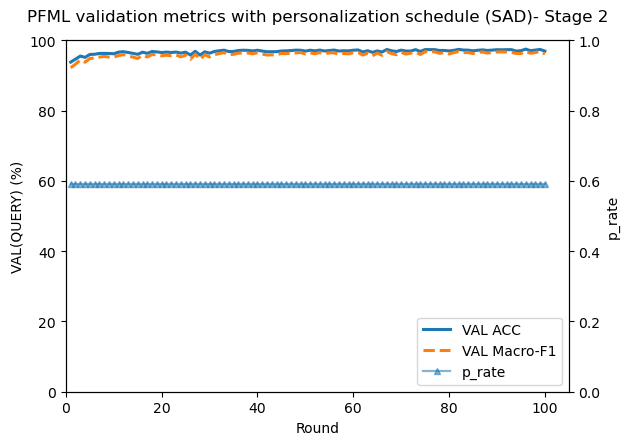

In [26]:
plot_pfml_history(trainer, save_dir="pfml_plots")

In [24]:

# ============================================================
# 8) FINAL TEST (load best VAL checkpoint)
# ============================================================
best_meta_path   = f"{save_prefix}_bestVAL_meta.json"
best_global_path = f"{save_prefix}_bestVAL_global.pth"
best_hyper_path  = f"{save_prefix}_bestVAL_hypernet.pth"
best_embed_path  = f"{save_prefix}_bestVAL_embed.pth"

best_p_rate = P_RATE
if os.path.exists(best_meta_path):
    import json
    with open(best_meta_path, "r") as f:
        meta = json.load(f)
    best_p_rate = float(meta.get("best_p_rate", P_RATE))
    print(
        f"[BEST META] best_round={meta.get('best_round')} "
        f"best_val_acc={meta.get('best_val_acc')} "
        f"best_p_rate={best_p_rate}"
    )

if os.path.exists(best_global_path):
    trainer.global_model.load_state_dict(
        torch.load(best_global_path, map_location=DEVICE),
        strict=True
    )
if os.path.exists(best_hyper_path):
    trainer.hypernet.load_state_dict(
        torch.load(best_hyper_path, map_location=DEVICE),
        strict=True
    )
if os.path.exists(best_embed_path):
    trainer.embed.load_state_dict(
        torch.load(best_embed_path, map_location=DEVICE),
        strict=True
    )

# ============================================================
# 9) TEST once (paper-grade)
# ============================================================
eval_test_per_subject_pfml(
    trainer,
    p_rate=best_p_rate,
    tag="FINAL_TEST",
    print_per_subject=True,
    save_txt=True,
    out_path=f"{save_prefix}_FINAL_TEST_detail.txt"
)

[BEST META] best_round=96 best_val_acc=0.9753637313842773 best_p_rate=0.591


C:\Users\user00\AppData\Local\Temp\ipykernel_69196\3438542971.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(best_global_path, map_location=DEVICE),
C:\User


================ PFML FINAL_TEST (TEST) ================
Subjects used : 12
Mean ACC      : 95.34%  (Std 1.80%)
Mean Macro-F1 : 93.29%  (Std 3.27%)
Overall Confusion Matrix (all test samples):
[[1255   94]
 [ 130 2913]]

Per-subject results:
  cid |     N |   ACC   | Macro-F1
------|-------|---------|---------
    0 |   265 |  96.98% |   94.99%
    1 |   567 |  95.41% |   93.04%
    2 |   344 |  93.90% |   92.24%
    3 |   195 |  94.87% |   91.48%
    4 |   239 |  96.65% |   96.02%
    5 |   152 |  97.37% |   97.08%
    6 |   617 |  91.90% |   91.86%
    7 |   121 |  98.35% |   98.27%
    8 |   510 |  94.51% |   90.39%
    9 |   836 |  95.81% |   94.90%
   10 |   273 |  94.51% |   86.16%
   11 |   273 |  93.77% |   93.09%



([{'cid': 0,
   'n': 265,
   'acc': 0.969811320754717,
   'macro_f1': 0.9499244142101286,
   'cm': array([[ 45,   5],
          [  3, 212]], dtype=int64)},
  {'cid': 1,
   'n': 567,
   'acc': 0.9541446208112875,
   'macro_f1': 0.9304386395379562,
   'cm': array([[105,  18],
          [  8, 436]], dtype=int64)},
  {'cid': 2,
   'n': 344,
   'acc': 0.938953488372093,
   'macro_f1': 0.9223684917521895,
   'cm': array([[241,   8],
          [ 13,  82]], dtype=int64)},
  {'cid': 3,
   'n': 195,
   'acc': 0.9487179487179487,
   'macro_f1': 0.914832285115304,
   'cm': array([[ 31,   0],
          [ 10, 154]], dtype=int64)},
  {'cid': 4,
   'n': 239,
   'acc': 0.9665271966527197,
   'macro_f1': 0.9602461743180306,
   'cm': array([[ 68,   3],
          [  5, 163]], dtype=int64)},
  {'cid': 5,
   'n': 152,
   'acc': 0.9736842105263158,
   'macro_f1': 0.9707692307692307,
   'cm': array([[50,  4],
          [ 0, 98]], dtype=int64)},
  {'cid': 6,
   'n': 617,
   'acc': 0.9189627228525121,
   'macro